In [2]:
import numpy as np
import pandas as pd
import torch

from Bio.Seq import Seq

from scipy import stats
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer
import xgboost as xgb

# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics
import matplotlib.pyplot as plt

import pickle

In [3]:
data_dir = "/data/rajan/integrase"
emb_dir = f"{data_dir}/emb"
esm2_3B_emb_dir = f"{emb_dir}/esm2_3B"
ORF_emb_dir = f"{esm2_3B_emb_dir}/ORF"
seq_emb_dir = f"{esm2_3B_emb_dir}/seqs"
attB_emb_dir = f"{esm2_3B_emb_dir}/attB"
attP_emb_dir = f"{esm2_3B_emb_dir}/attP"
fasta_dir = f"{data_dir}/fasta"

In [4]:
data = pickle.load(open('/home/rajan/integrase/data.pkl', 'rb'))
data.head()

,#,Int Name,Efficiency,ATTB,ATTP,ORF,seq,seq_mean_emb,sqrt_eff,yj_eff,bcx_eff
0,1,Int1,8.454545,ggaactccgccgggcccatctggtcgaagaagatgaaggggcccac...,atggggtcacaataccaatcatgttcaagaatgtgaagggtatttt...,ATGACCAACCCCGCCTCCAGACCTAAGGCCTACAGCTACATCAGAA...,MTNPASRPKAYSYIRMSSAIQIKGDSFRRQAEASAKYAAEHDLDLI...,"[-0.012143803, -0.0052933423, -0.0072857062, 0...",2.907670,2.748843,3.072296
1,2,Int2,29.568182,ggacggcgcagaaggggagtagctcttcgccggaccgtcgacatac...,gctcatgtatgtgtctacgcgagattctcgcccgagaacttctgca...,ATGCCTATCGCCCCTGAGTTCCTGTCTCTGGCTTATCCTGGACAGG...,MPIAPEFLSLAYPGQEFPAYLYGRASRDPKRKGRSVQSQLDEGRAT...,"[0.018540306, -0.026513908, -0.039321538, 0.02...",5.437663,4.673390,6.144307
2,3,Int3,14.636364,gtttgtaaaggagactgataatggcatgtacaactatactcgtcgg...,atggataaaaaaatacagcgtttttcatgtacaactatactagttg...,ATGCGGAAGGTGGCCATCTATAGCCGGGTGTCTACAATTAACCAAG...,MRKVAIYSRVSTINQAEEGYSIQGQIEALTKYCEAMEWKIYKNYSD...,"[-0.018123832, -0.008340224, -0.046946924, 0.0...",3.825750,3.526112,4.267895
3,4,Int4,31.500000,ttccaaagagcgcccaacgcgacctgaaatttgaataagactgctg...,caaaaattacaaagttttcaacccttgatttgaattagcggtcaaa...,ATGATCACAACCAGGAAGGTGGCCATCTACGTGCGGGTGTCCACCA...,MITTRKVAIYVRVSTTNQAEEGYSIQGQIDSLIKYCEAMGWIIYEE...,"[-0.0050011743, -0.0090518985, -0.056376845, 0...",5.612486,4.785097,6.335013
4,5,Int5,14.568182,gagcgccggatcagggagtggacggcctgggagcgctacacgctgt...,ccctaatacgcaagtcgataactctcctgggagcgttgacaacttg...,ATGCCAGGGATGACCACAGAAACCGGACCTGACCCAGCCGGACTTA...,MPGMTTETGPDPAGLIDLFCRKSKAVKSRANGAGQRRKQEISIAAQ...,"[0.02901023, -0.012837757, -0.04548945, 0.0252...",3.816829,3.519063,4.256804


In [5]:
pt_yj_wo_std = PowerTransformer(method='yeo-johnson', standardize=False)
pt_yj_wo_std.fit(data.Efficiency.values.reshape(-1, 1))
print(pt_yj_wo_std.lambdas_)

yj_wo_std_eff = pt_yj_wo_std.transform(data.Efficiency.values.reshape(-1, 1))
data["yj_eff"] = yj_wo_std_eff

print(min(yj_wo_std_eff), max(yj_wo_std_eff))

inv_yj_wo_std_eff = pt_yj_wo_std.inverse_transform(yj_wo_std_eff)

[0.17400427]
[0.00253371] [6.45023616]


In [36]:
def plot_true_v_pred(true, pred, title):
    plt.figure(figsize=(10,10))
    plt.scatter(true, pred, c='crimson')
    p1 = max(max(pred), max(true))
    p2 = min(min(pred), min(true))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True efficiency', fontsize=15)
    plt.ylabel('Predicted efficiency', fontsize=15)
    plt.axis('equal')
    plt.title(title, fontsize=15)
    plt.show()

### Train-test split

In [7]:
X = data[["seq_mean_emb"]]
y = data.yj_eff

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
X_train_vals = np.vstack(X_train['seq_mean_emb'])
y_train_vals = y_train.to_numpy()

X_test_vals = np.vstack(X_test['seq_mean_emb'])
y_test_vals = y_test.to_numpy()

### Random Forest Regressor

In [10]:
rf_mod = RandomForestRegressor(random_state=8)

In [11]:
rf_mod.fit(X_train_vals, y_train_vals)

RandomForestRegressor(random_state=8)

In [12]:
rf_mod.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}

##### Random Hyperparameter Grid

In [13]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['log2', 'sqrt', None], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


##### Random Search Training

In [14]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, error_score='raise')
# Fit the random search model
rf_random.fit(X_train_vals, y_train_vals)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, error_score='raise', estimator=RandomForestRegressor(),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [15]:
rf_random.best_params_


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 20,
 'bootstrap': True}

In [16]:
def evaluate(model, X, y):
    predictions = model.predict(X)
    errors = abs(predictions - y)
    # mean absolute percentage error
    mape = 100 * np.mean(errors / y)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train_vals, y_train_vals)
base_accuracy = evaluate(base_model, X_test_vals, y_test_vals)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_vals, y_test_vals)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.9642 degrees.
Accuracy = 72.16%.
Model Performance
Average Error: 0.8941 degrees.
Accuracy = 73.40%.
Improvement of 1.71%.


In [17]:
rf_random.best_params_


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 20,
 'bootstrap': True}

In [18]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 9, 10],
    'max_features': [2, 3, 'log2'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [8, 9, 10],
    'n_estimators': [80, 100, 150, 200, 250]
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [19]:
# Fit the grid search to the data
grid_search.fit(X_train_vals, y_train_vals)

grid_search.best_params_

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


{'bootstrap': True,
 'max_depth': 8,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 9,
 'n_estimators': 80}

In [20]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test_vals, y_test_vals)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.9088 degrees.
Accuracy = 72.71%.
Improvement of 0.76%.


In [21]:
y_hat_train = best_grid.predict(X_train_vals)
y_hat_test = best_grid.predict(X_test_vals)

In [22]:
# inverse yeo-johnshon transformation
inv_y_train = pt_yj_wo_std.inverse_transform(y_train_vals.reshape(-1, 1))
inv_y_test = pt_yj_wo_std.inverse_transform(y_test_vals.reshape(-1, 1))

inv_y_hat_train = pt_yj_wo_std.inverse_transform(y_hat_train.reshape(-1, 1))
inv_y_hat_test = pt_yj_wo_std.inverse_transform(y_hat_test.reshape(-1, 1))

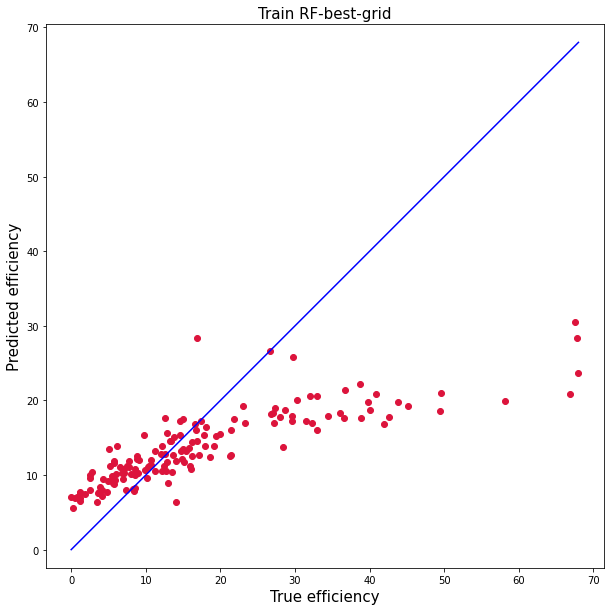

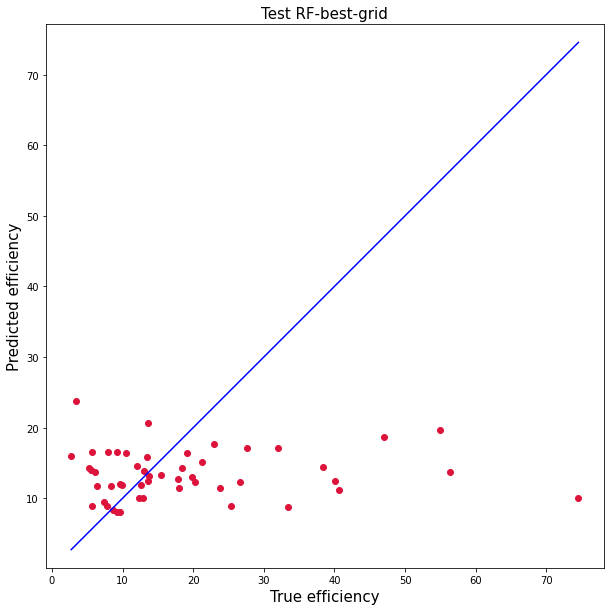

In [23]:
plot_true_v_pred(inv_y_train, inv_y_hat_train, "Train RF-best-grid")
plot_true_v_pred(inv_y_test, inv_y_hat_test, "Test RF-best-grid")

In [24]:
def display_metrics(y_true, y_pred, label):
    print('**',label,'**')
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
    print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
    print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
    print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
    print('Max Error:', metrics.max_error(y_true, y_pred))
    print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
    print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
    print('R^2:', metrics.r2_score(y_true, y_pred))
    print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
    print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))

In [25]:
display_metrics(inv_y_train, inv_y_hat_train, 'Train')

** Train **
Mean Absolute Error (MAE): 7.434812003557832
Mean Squared Error (MSE): 134.3991990168987
Root Mean Squared Error (RMSE): 11.593066851221842
Mean Absolute Percentage Error (MAPE): 19.46295182752466
Explained Variance Score: 0.44579902288930484
Max Error: 45.99595306262602
Mean Squared Log Error: 0.35503908939462436
Median Absolute Error: 4.171094758825616
R^2: 0.37823348875636176
Mean Poisson Deviance: 5.800693277215241
Mean Gamma Deviance: 0.49879665884300567


In [26]:
display_metrics(inv_y_test, inv_y_hat_test, 'Test')

** Test **
Mean Absolute Error (MAE): 10.529234721977993
Mean Squared Error (MSE): 266.097496533298
Root Mean Squared Error (RMSE): 16.31249510446817
Mean Absolute Percentage Error (MAPE): 0.6946000312298934
Explained Variance Score: -0.025215841110293402
Max Error: 64.53861090444587
Mean Squared Log Error: 0.5231356521005669
Median Absolute Error: 6.346586166635275
R^2: -0.1609325865854101
Mean Poisson Deviance: 12.846791627113362
Mean Gamma Deviance: 0.7574533315329256


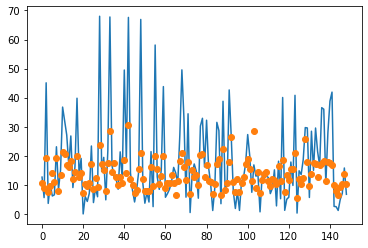

In [27]:
plt.plot(inv_y_train)
plt.plot(inv_y_hat_train, 'o')

plt.show()

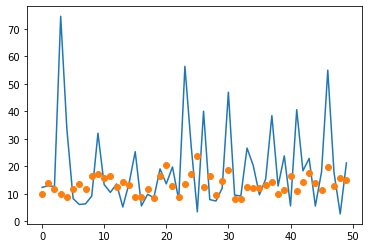

In [28]:
plt.plot(inv_y_test)
plt.plot(inv_y_hat_test, 'o')

plt.show()

### Gradient Boosting Regression

In [29]:
param_grid = {
    'learning_rate' : [0.001, 0.01, 0.1],
    # 'loss': ['squared_error', 'absolute_error', 'huber'],
    'max_depth': [7, 8, 9],
    # 'min_samples_leaf': [2, 3, 4],
    # 'min_samples_split': [8, 9, 10],
    'n_estimators': [80, 100, 120]
}

# Create a based model
xgb_mod = xgb.XGBRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb_mod, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_vals, y_train_vals)

grid_search.best_params_


Fitting 3 folds for each of 27 candidates, totalling 81 fits


{'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 80}

In [30]:

best_xgb_mod = grid_search.best_estimator_
grid_accuracy = evaluate(best_xgb_mod, X_test_vals, y_test_vals)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.9003 degrees.
Accuracy = 73.48%.
Improvement of 1.82%.


In [31]:
y_hat_train = best_xgb_mod.predict(X_train_vals)
y_hat_test = best_xgb_mod.predict(X_test_vals)

In [32]:
# inverse yeo-johnshon transformation
inv_y_train = pt_yj_wo_std.inverse_transform(y_train_vals.reshape(-1, 1))
inv_y_test = pt_yj_wo_std.inverse_transform(y_test_vals.reshape(-1, 1))

inv_y_hat_train = pt_yj_wo_std.inverse_transform(y_hat_train.reshape(-1, 1))
inv_y_hat_test = pt_yj_wo_std.inverse_transform(y_hat_test.reshape(-1, 1))

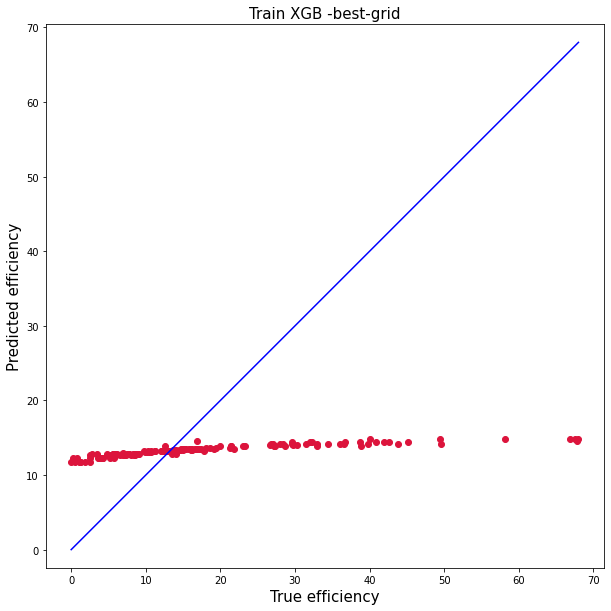

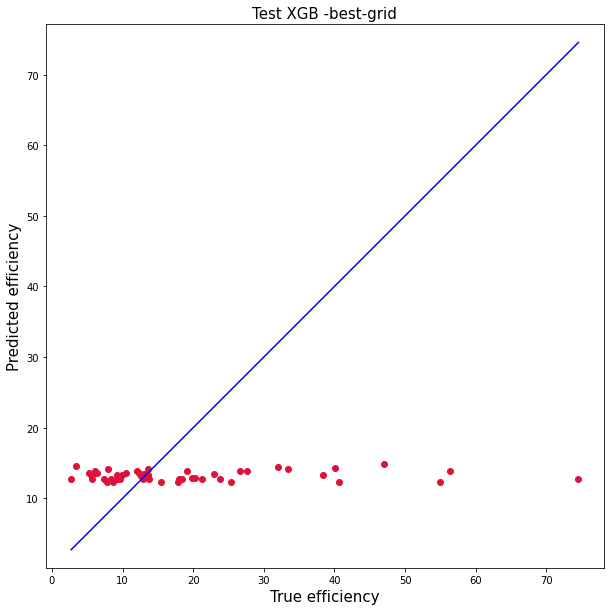

In [33]:
plot_true_v_pred(inv_y_train, inv_y_hat_train, "Train XGB -best-grid")
plot_true_v_pred(inv_y_test, inv_y_hat_test, "Test XGB -best-grid")

In [34]:
display_metrics(inv_y_train, inv_y_hat_train, 'XGB-Train')

** XGB-Train **
Mean Absolute Error (MAE): 9.88538449179164
Mean Squared Error (MSE): 214.62267944748996
Root Mean Squared Error (RMSE): 14.650006124486431
Mean Absolute Percentage Error (MAPE): 32.608556793697936
Explained Variance Score: 0.08829615960351278
Max Error: 53.19264507293698
Mean Squared Log Error: 0.6543545409517046
Median Absolute Error: 6.6176328277587935
R^2: 0.007098289201494579
Mean Poisson Deviance: 10.83785208144475
Mean Gamma Deviance: 0.8411775464960004


In [35]:
display_metrics(inv_y_test, inv_y_hat_test, 'XGB-Test')

** XGB-Test **
Mean Absolute Error (MAE): 10.416932145552195
Mean Squared Error (MSE): 261.2990974921318
Root Mean Squared Error (RMSE): 16.164748605905746
Mean Absolute Percentage Error (MAPE): 0.6312708906894843
Explained Variance Score: 0.004800124639160797
Max Error: 61.80496864318839
Mean Squared Log Error: 0.47376581465376844
Median Absolute Error: 6.610159691897295
R^2: -0.1399980874529354
Mean Poisson Deviance: 12.236551131742258
Mean Gamma Deviance: 0.6885253959228246
